In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

2023-03-15 21:08:48.655351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df1 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jan2_finalDS/QuantizedTrainSet.csv')
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,y-local
0,0,0,0,0,0,3,6,0,0,0,0,0,0,56
1,0,0,0,3,4,0,0,0,0,0,0,0,0,45
2,0,0,0,0,0,3,4,0,0,0,0,0,0,42
3,0,0,0,0,2,4,0,0,0,0,0,0,0,56
4,0,0,0,0,0,5,26,0,0,0,0,0,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652155,0,0,0,14,25,0,0,0,0,0,0,0,0,34
652156,0,0,0,0,1,2,4,2,0,0,0,0,0,29
652157,0,2,10,10,9,9,0,0,0,0,0,0,0,7
652158,0,0,0,0,3,0,0,0,0,0,0,0,0,51


In [3]:
df2 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jan2_finalDS/TrainSetLabel.csv')
df2

,ptLabel
0,0
1,0
2,0
3,1
4,1
...,...
652155,1
652156,2
652157,0
652158,1


In [4]:
df3 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jan2_finalDS/QuantizedTestSet.csv')
df3

,0,1,2,3,4,5,6,7,8,9,10,11,12,y-local
0,0,0,0,3,5,3,5,5,0,0,0,0,0,7
1,0,0,1,3,3,5,3,3,0,0,0,0,0,0
2,0,0,0,1,4,3,3,3,1,0,0,0,0,6
3,0,0,2,2,2,1,0,0,0,0,0,0,0,29
4,0,0,0,0,1,20,15,0,0,0,0,0,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163035,0,0,0,1,2,2,1,0,0,0,0,0,0,33
163036,0,0,0,0,0,30,17,0,0,0,0,0,0,39
163037,0,0,0,3,3,0,0,0,0,0,0,0,0,39
163038,0,0,0,0,0,0,23,6,0,0,0,0,0,58


In [5]:
df4 = pd.read_csv('/uscms/home/jieun201/nobackup/YOURWORKINGAREA/jan2_finalDS/TestSetLabel.csv')
df4

,ptLabel
0,0
1,2
2,0
3,2
4,0
...,...
163035,0
163036,1
163037,0
163038,1


In [6]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(652160, 14) (163040, 14) (652160, 1) (163040, 1)


In [7]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [9]:
X_test

array([[-0.0829556 , -0.15511087, -0.37039814, ..., -0.0638341 ,
        -0.05527447, -1.3711819 ],
       [-0.0829556 , -0.15511087,  0.28603854, ..., -0.0638341 ,
        -0.05527447, -1.75990181],
       [-0.0829556 , -0.15511087, -0.37039814, ..., -0.0638341 ,
        -0.05527447, -1.42671332],
       ...,
       [-0.0829556 , -0.15511087, -0.37039814, ..., -0.0638341 ,
        -0.05527447,  0.40582339],
       [-0.0829556 , -0.15511087, -0.37039814, ..., -0.0638341 ,
        -0.05527447,  1.46092028],
       [-0.0829556 , -0.15511087, -0.37039814, ..., -0.0638341 ,
        -0.05527447,  1.68304594]])

In [10]:
from tensorflow.keras.layers import Input, Activation
from qkeras import *

def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDense(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = QActivation("quantized_relu(10,0)", name="relu-1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model
    
model=CreateQModel(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

2023-03-15 21:08:53.820870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 21:08:53.850487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 21:08:53.850797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 21:08:53.851609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense1 (QDense)             (None, 128)               1920      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 relu-1 (QActivation)        (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 3)                 387       
                                                                 
 softmax (Activation)        (None, 3)                 0         
                                                             

In [11]:
es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=20,
                                   restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/150
 56/510 [==>...........................] - ETA: 1s - loss: 1.0857 - sparse_categorical_accuracy: 0.4380 

2023-03-15 21:08:56.842579: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


510/510 [==============================] - 3s 3ms/step - loss: 0.8990 - sparse_categorical_accuracy: 0.5682 - val_loss: 0.7866 - val_sparse_categorical_accuracy: 0.6217
Epoch 2/150
510/510 [==============================] - 1s 3ms/step - loss: 0.7309 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.6921
Epoch 3/150
510/510 [==============================] - 2s 3ms/step - loss: 0.6763 - sparse_categorical_accuracy: 0.6936 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.6991
Epoch 4/150
510/510 [==============================] - 1s 3ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.6461 - val_sparse_categorical_accuracy: 0.7121
Epoch 5/150
510/510 [==============================] - 1s 3ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7077 - val_loss: 0.6368 - val_sparse_categorical_accuracy: 0.7100
Epoch 6/150
510/510 [==============================] - 1s 3ms/step - loss: 0.6373 - sparse_categorical_accu

In [12]:
#save model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
#model.save('my_model.tf')
model.save('/home/jieun201/dataset9_QKeras/my_model.tf')

INFO:tensorflow:Assets written to: /home/jieun201/dataset9_QKeras/my_model.tf/assets


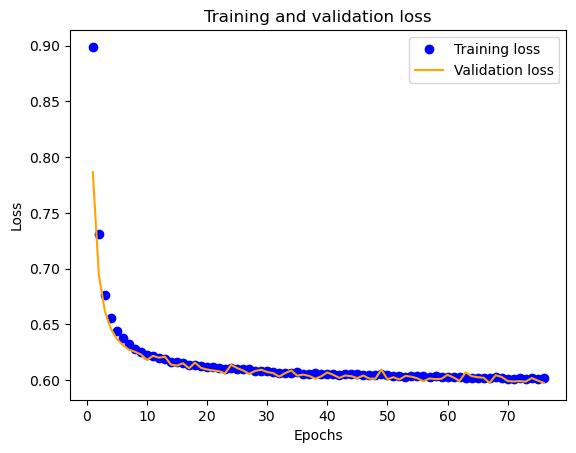

In [13]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')

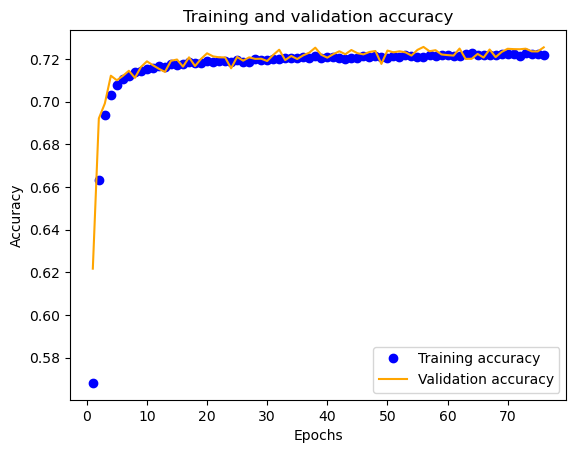

In [14]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#np.max(val_acc)
plt.savefig('accuracy.png')
plt.show()

In [15]:
preds = model.predict(X_test) 
predictionsFiles =np.argmax(preds, axis=1)

5095/5095 [==============================] - 6s 1ms/step


In [16]:
#pd.DataFrame(predictionsFiles).to_csv("predictionsFiles.csv",header='predict', index=False)

In [17]:
#pd.DataFrame(y_test).to_csv("true.csv",header='true', index=False)

In [18]:
#score = model.evaluate(X_test, y_test, verbose=0)
#print("Test loss:", score[0])
#print("Test accuracy:", score[1])

In [19]:
#from sklearn import datasets, svm, metrics
#disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
#disp.figure_.suptitle("Multiclassifier Confusion Matrix")
##print(f"Confusion matrix:\n{disp.confusion_matrix}")
#plt.savefig('confusionMatrix.png')
#plt.show()